##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# オートエンコーダの基礎

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png"> ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、基本、画像のノイズ除去、異常検出の3つの例を使用してオートエンコーダを紹介します。

オートエンコーダは、入力を出力にコピーするようにトレーニングされた特殊なタイプのニューラルネットワークです。たとえば、手書きの数字の画像が与えられた場合、オートエンコーダは最初に画像を低次元の潜在表現にエンコードし、次に潜在表現をデコードして画像に戻します。オートエンコーダは、再構成エラーを最小限に抑えながらデータを圧縮することを学習します。

オートエンコーダの詳細については、Ian Goodfellow、Yoshua Bengio、AaronCourville による[ディープラーニング](https://www.deeplearningbook.org/)の第 14 章を参照してください。

## TensorFlow とその他のライブラリをインポートする

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2024-01-11 23:00:50.693016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 23:00:50.693063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 23:00:50.694811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## データセットを読み込む

まず、Fashion MNIST データセットを使用して基本的なオートエンコーダーをトレーニングします。このデータセットの各画像は 28x28 ピクセルです。 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## 最初の例：オートエンコーダの基本

![Basic autoencoder results](images/intro_autoencoder_result.png)

次の2つの高密度レイヤーでオートエンコーダーを定義します。`encoder` は、画像を 64 次元の潜在ベクトルに圧縮します。`decoder` は、潜在空間から元の画像を再構築します。

モデルを定義するには、[Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models) を使用します。


In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

入力とターゲットの両方として `x_train` を使用してモデルをトレーニングします。`encoder` は、データセットを 784 次元から潜在空間に圧縮することを学習し、`decoder` は元の画像を再構築することを学習します。

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1705014057.892644 1057381 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/1875 [..............................] - ETA: 48:28 - loss: 0.1695

  24/1875 [..............................] - ETA: 4s - loss: 0.1339   

  49/1875 [..............................] - ETA: 3s - loss: 0.1062

  73/1875 [>.............................] - ETA: 3s - loss: 0.0928

  98/1875 [>.............................] - ETA: 3s - loss: 0.0826

 124/1875 [>.............................] - ETA: 3s - loss: 0.0756

 149/1875 [=>............................] - ETA: 3s - loss: 0.0702

 175/1875 [=>............................] - ETA: 3s - loss: 0.0658

 201/1875 [==>...........................] - ETA: 3s - loss: 0.0621

 227/1875 [==>...........................] - ETA: 3s - loss: 0.0589

 253/1875 [===>..........................] - ETA: 3s - loss: 0.0563

 279/1875 [===>..........................] - ETA: 3s - loss: 0.0539

 305/1875 [===>..........................] - ETA: 3s - loss: 0.0519

 328/1875 [====>.........................] - ETA: 3s - loss: 0.0503

 353/1875 [====>.........................] - ETA: 3s - loss: 0.0487

 378/1875 [=====>........................] - ETA: 3s - loss: 0.0473

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0459

 429/1875 [=====>........................] - ETA: 2s - loss: 0.0448

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0436

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0427

 506/1875 [=======>......................] - ETA: 2s - loss: 0.0417

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0409

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0400

 584/1875 [========>.....................] - ETA: 2s - loss: 0.0393

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0385

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0378

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0372

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0366

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0360

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0355

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0349

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0344

 817/1875 [============>.................] - ETA: 2s - loss: 0.0340

 842/1875 [============>.................] - ETA: 2s - loss: 0.0335

 867/1875 [============>.................] - ETA: 2s - loss: 0.0331

 893/1875 [=============>................] - ETA: 1s - loss: 0.0327

 918/1875 [=============>................] - ETA: 1s - loss: 0.0323

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0320

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0316

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0313

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0310

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0306

1074/1875 [================>.............] - ETA: 1s - loss: 0.0303

1100/1875 [================>.............] - ETA: 1s - loss: 0.0300

1127/1875 [=================>............] - ETA: 1s - loss: 0.0297

1153/1875 [=================>............] - ETA: 1s - loss: 0.0294

1180/1875 [=================>............] - ETA: 1s - loss: 0.0291

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0288

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0285

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0283

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0280

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0278

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0275

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0273

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0271

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0269

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0266

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0264

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0262

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0260

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0258

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0256

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0254

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0253

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0251

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0249

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0248

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0246

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0244

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0243

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0241

1830/1875 [============================>.] - ETA: 0s - loss: 0.0240

1855/1875 [============================>.] - ETA: 0s - loss: 0.0238

1875/1875 [==============================] - 6s 2ms/step - loss: 0.0237 - val_loss: 0.0136


Epoch 2/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0163

  27/1875 [..............................] - ETA: 3s - loss: 0.0133

  52/1875 [..............................] - ETA: 3s - loss: 0.0134

  76/1875 [>.............................] - ETA: 3s - loss: 0.0133

 100/1875 [>.............................] - ETA: 3s - loss: 0.0133

 124/1875 [>.............................] - ETA: 3s - loss: 0.0132

 149/1875 [=>............................] - ETA: 3s - loss: 0.0131

 173/1875 [=>............................] - ETA: 3s - loss: 0.0131

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0131

 294/1875 [===>..........................] - ETA: 3s - loss: 0.0130

 318/1875 [====>.........................] - ETA: 3s - loss: 0.0129

 344/1875 [====>.........................] - ETA: 3s - loss: 0.0129

 369/1875 [====>.........................] - ETA: 3s - loss: 0.0129

 394/1875 [=====>........................] - ETA: 3s - loss: 0.0129

 419/1875 [=====>........................] - ETA: 3s - loss: 0.0129

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0128

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0128

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0128

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0128

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0127

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0127

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0127

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0126

 668/1875 [=========>....................] - ETA: 2s - loss: 0.0126

 692/1875 [==========>...................] - ETA: 2s - loss: 0.0126

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0125

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0125

 768/1875 [===========>..................] - ETA: 2s - loss: 0.0125

 793/1875 [===========>..................] - ETA: 2s - loss: 0.0125

 818/1875 [============>.................] - ETA: 2s - loss: 0.0124

 844/1875 [============>.................] - ETA: 2s - loss: 0.0124

 869/1875 [============>.................] - ETA: 2s - loss: 0.0124

 894/1875 [=============>................] - ETA: 2s - loss: 0.0124

 919/1875 [=============>................] - ETA: 1s - loss: 0.0124

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0123

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0123

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0123

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0123

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1069/1875 [================>.............] - ETA: 1s - loss: 0.0122

1094/1875 [================>.............] - ETA: 1s - loss: 0.0122

1119/1875 [================>.............] - ETA: 1s - loss: 0.0122

1146/1875 [=================>............] - ETA: 1s - loss: 0.0122

1172/1875 [=================>............] - ETA: 1s - loss: 0.0121

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0121

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0121

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0119

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0119

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0118

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1824/1875 [============================>.] - ETA: 0s - loss: 0.0117

1850/1875 [============================>.] - ETA: 0s - loss: 0.0117

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0106


Epoch 3/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0112

  26/1875 [..............................] - ETA: 3s - loss: 0.0107

  52/1875 [..............................] - ETA: 3s - loss: 0.0106

  77/1875 [>.............................] - ETA: 3s - loss: 0.0105

 102/1875 [>.............................] - ETA: 3s - loss: 0.0105

 128/1875 [=>............................] - ETA: 3s - loss: 0.0104

 153/1875 [=>............................] - ETA: 3s - loss: 0.0103

 178/1875 [=>............................] - ETA: 3s - loss: 0.0104

 204/1875 [==>...........................] - ETA: 3s - loss: 0.0104

 231/1875 [==>...........................] - ETA: 3s - loss: 0.0104

 258/1875 [===>..........................] - ETA: 3s - loss: 0.0103

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0104

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0104

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0103

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0103

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0103

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0103

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0103

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0103

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 580/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 686/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 712/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0103

 793/1875 [===========>..................] - ETA: 2s - loss: 0.0103

 819/1875 [============>.................] - ETA: 2s - loss: 0.0103

 845/1875 [============>.................] - ETA: 1s - loss: 0.0103

 871/1875 [============>.................] - ETA: 1s - loss: 0.0103

 898/1875 [=============>................] - ETA: 1s - loss: 0.0102

 924/1875 [=============>................] - ETA: 1s - loss: 0.0102

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0102

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0102

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0102

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0102

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0102

1078/1875 [================>.............] - ETA: 1s - loss: 0.0102

1103/1875 [================>.............] - ETA: 1s - loss: 0.0102

1127/1875 [=================>............] - ETA: 1s - loss: 0.0102

1151/1875 [=================>............] - ETA: 1s - loss: 0.0102

1177/1875 [=================>............] - ETA: 1s - loss: 0.0102

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0101

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0101

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0101

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0101

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0101

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0100

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0100

1837/1875 [============================>.] - ETA: 0s - loss: 0.0100

1863/1875 [============================>.] - ETA: 0s - loss: 0.0100

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0098


Epoch 4/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0080

  26/1875 [..............................] - ETA: 3s - loss: 0.0094

  51/1875 [..............................] - ETA: 3s - loss: 0.0093

  77/1875 [>.............................] - ETA: 3s - loss: 0.0095

 103/1875 [>.............................] - ETA: 3s - loss: 0.0096

 129/1875 [=>............................] - ETA: 3s - loss: 0.0096

 153/1875 [=>............................] - ETA: 3s - loss: 0.0095

 179/1875 [=>............................] - ETA: 3s - loss: 0.0095

 205/1875 [==>...........................] - ETA: 3s - loss: 0.0095

 232/1875 [==>...........................] - ETA: 3s - loss: 0.0095

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0096

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0096

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0096

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0095

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0095

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0095

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0095

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0095

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0095

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0095

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0095

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0095

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0095

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 686/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 712/1875 [==========>...................] - ETA: 2s - loss: 0.0096

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0096

 764/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0095

 818/1875 [============>.................] - ETA: 2s - loss: 0.0095

 845/1875 [============>.................] - ETA: 1s - loss: 0.0095

 872/1875 [============>.................] - ETA: 1s - loss: 0.0095

 899/1875 [=============>................] - ETA: 1s - loss: 0.0095

 925/1875 [=============>................] - ETA: 1s - loss: 0.0095

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0095

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0095

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0095

1085/1875 [================>.............] - ETA: 1s - loss: 0.0095

1112/1875 [================>.............] - ETA: 1s - loss: 0.0095

1139/1875 [=================>............] - ETA: 1s - loss: 0.0095

1166/1875 [=================>............] - ETA: 1s - loss: 0.0095

1192/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0095

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0095

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0095

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0095

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0095

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0095

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0095

1515/1875 [=======================>......] - ETA: 0s - loss: 0.0095

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0095

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1836/1875 [============================>.] - ETA: 0s - loss: 0.0094

1864/1875 [============================>.] - ETA: 0s - loss: 0.0094

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0093


Epoch 5/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0095

  26/1875 [..............................] - ETA: 3s - loss: 0.0092

  52/1875 [..............................] - ETA: 3s - loss: 0.0094

  78/1875 [>.............................] - ETA: 3s - loss: 0.0094

 104/1875 [>.............................] - ETA: 3s - loss: 0.0093

 130/1875 [=>............................] - ETA: 3s - loss: 0.0094

 157/1875 [=>............................] - ETA: 3s - loss: 0.0094

 185/1875 [=>............................] - ETA: 3s - loss: 0.0093

 212/1875 [==>...........................] - ETA: 3s - loss: 0.0094

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0094

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0094

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0094

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0093

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0093

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0093

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0093

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0093

 559/1875 [=======>......................] - ETA: 2s - loss: 0.0093

 586/1875 [========>.....................] - ETA: 2s - loss: 0.0093

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0093

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0093

 694/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0092

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0092

 831/1875 [============>.................] - ETA: 1s - loss: 0.0092

 858/1875 [============>.................] - ETA: 1s - loss: 0.0092

 885/1875 [=============>................] - ETA: 1s - loss: 0.0092

 910/1875 [=============>................] - ETA: 1s - loss: 0.0092

 937/1875 [=============>................] - ETA: 1s - loss: 0.0092

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0092

 990/1875 [==============>...............] - ETA: 1s - loss: 0.0092

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1070/1875 [================>.............] - ETA: 1s - loss: 0.0092

1096/1875 [================>.............] - ETA: 1s - loss: 0.0092

1122/1875 [================>.............] - ETA: 1s - loss: 0.0092

1149/1875 [=================>............] - ETA: 1s - loss: 0.0092

1176/1875 [=================>............] - ETA: 1s - loss: 0.0092

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0092

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1822/1875 [============================>.] - ETA: 0s - loss: 0.0092

1850/1875 [============================>.] - ETA: 0s - loss: 0.0092

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092


Epoch 6/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0085

  28/1875 [..............................] - ETA: 3s - loss: 0.0087

  55/1875 [..............................] - ETA: 3s - loss: 0.0089

  82/1875 [>.............................] - ETA: 3s - loss: 0.0091

 109/1875 [>.............................] - ETA: 3s - loss: 0.0091

 137/1875 [=>............................] - ETA: 3s - loss: 0.0091

 165/1875 [=>............................] - ETA: 3s - loss: 0.0091

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0090

 301/1875 [===>..........................] - ETA: 2s - loss: 0.0090

 328/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0091

 382/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 436/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0091

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 677/1875 [=========>....................] - ETA: 2s - loss: 0.0091

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 754/1875 [===========>..................] - ETA: 2s - loss: 0.0091

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 836/1875 [============>.................] - ETA: 1s - loss: 0.0090

 863/1875 [============>.................] - ETA: 1s - loss: 0.0090

 890/1875 [=============>................] - ETA: 1s - loss: 0.0090

 917/1875 [=============>................] - ETA: 1s - loss: 0.0090

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0090

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1078/1875 [================>.............] - ETA: 1s - loss: 0.0090

1105/1875 [================>.............] - ETA: 1s - loss: 0.0090

1133/1875 [=================>............] - ETA: 1s - loss: 0.0090

1160/1875 [=================>............] - ETA: 1s - loss: 0.0090

1187/1875 [=================>............] - ETA: 1s - loss: 0.0090

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1292/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1371/1875 [====================>.........] - ETA: 0s - loss: 0.0090

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1823/1875 [============================>.] - ETA: 0s - loss: 0.0090

1850/1875 [============================>.] - ETA: 0s - loss: 0.0090

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 7/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0080

  27/1875 [..............................] - ETA: 3s - loss: 0.0086

  53/1875 [..............................] - ETA: 3s - loss: 0.0089

  79/1875 [>.............................] - ETA: 3s - loss: 0.0090

 105/1875 [>.............................] - ETA: 3s - loss: 0.0090

 131/1875 [=>............................] - ETA: 3s - loss: 0.0089

 158/1875 [=>............................] - ETA: 3s - loss: 0.0090

 185/1875 [=>............................] - ETA: 3s - loss: 0.0090

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 318/1875 [====>.........................] - ETA: 3s - loss: 0.0090

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0090

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0090

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 716/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 795/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 821/1875 [============>.................] - ETA: 2s - loss: 0.0089

 848/1875 [============>.................] - ETA: 1s - loss: 0.0089

 873/1875 [============>.................] - ETA: 1s - loss: 0.0089

 899/1875 [=============>................] - ETA: 1s - loss: 0.0089

 924/1875 [=============>................] - ETA: 1s - loss: 0.0089

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0089

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1075/1875 [================>.............] - ETA: 1s - loss: 0.0089

1100/1875 [================>.............] - ETA: 1s - loss: 0.0089

1125/1875 [=================>............] - ETA: 1s - loss: 0.0089

1151/1875 [=================>............] - ETA: 1s - loss: 0.0089

1176/1875 [=================>............] - ETA: 1s - loss: 0.0089

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1331/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1826/1875 [============================>.] - ETA: 0s - loss: 0.0089

1853/1875 [============================>.] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0090


Epoch 8/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0076

  27/1875 [..............................] - ETA: 3s - loss: 0.0089

  53/1875 [..............................] - ETA: 3s - loss: 0.0088

  79/1875 [>.............................] - ETA: 3s - loss: 0.0089

 105/1875 [>.............................] - ETA: 3s - loss: 0.0089

 131/1875 [=>............................] - ETA: 3s - loss: 0.0088

 156/1875 [=>............................] - ETA: 3s - loss: 0.0089

 182/1875 [=>............................] - ETA: 3s - loss: 0.0089

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 232/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 312/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0089

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 680/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 706/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 784/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 835/1875 [============>.................] - ETA: 2s - loss: 0.0088

 861/1875 [============>.................] - ETA: 1s - loss: 0.0088

 887/1875 [=============>................] - ETA: 1s - loss: 0.0088

 913/1875 [=============>................] - ETA: 1s - loss: 0.0088

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1066/1875 [================>.............] - ETA: 1s - loss: 0.0088

1091/1875 [================>.............] - ETA: 1s - loss: 0.0088

1117/1875 [================>.............] - ETA: 1s - loss: 0.0088

1142/1875 [=================>............] - ETA: 1s - loss: 0.0088

1168/1875 [=================>............] - ETA: 1s - loss: 0.0088

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1375/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1837/1875 [============================>.] - ETA: 0s - loss: 0.0088

1863/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


Epoch 9/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0075

  28/1875 [..............................] - ETA: 3s - loss: 0.0086

  55/1875 [..............................] - ETA: 3s - loss: 0.0086

  82/1875 [>.............................] - ETA: 3s - loss: 0.0086

 109/1875 [>.............................] - ETA: 3s - loss: 0.0087

 136/1875 [=>............................] - ETA: 3s - loss: 0.0087

 162/1875 [=>............................] - ETA: 3s - loss: 0.0087

 189/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 241/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 291/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 317/1875 [====>.........................] - ETA: 3s - loss: 0.0088

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 837/1875 [============>.................] - ETA: 2s - loss: 0.0088

 864/1875 [============>.................] - ETA: 1s - loss: 0.0088

 890/1875 [=============>................] - ETA: 1s - loss: 0.0088

 917/1875 [=============>................] - ETA: 1s - loss: 0.0088

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1076/1875 [================>.............] - ETA: 1s - loss: 0.0088

1103/1875 [================>.............] - ETA: 1s - loss: 0.0088

1130/1875 [=================>............] - ETA: 1s - loss: 0.0088

1157/1875 [=================>............] - ETA: 1s - loss: 0.0088

1184/1875 [=================>............] - ETA: 1s - loss: 0.0088

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0088

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1817/1875 [============================>.] - ETA: 0s - loss: 0.0088

1843/1875 [============================>.] - ETA: 0s - loss: 0.0088

1869/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0090


Epoch 10/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0093

  27/1875 [..............................] - ETA: 3s - loss: 0.0084

  53/1875 [..............................] - ETA: 3s - loss: 0.0087

  80/1875 [>.............................] - ETA: 3s - loss: 0.0088

 106/1875 [>.............................] - ETA: 3s - loss: 0.0087

 131/1875 [=>............................] - ETA: 3s - loss: 0.0087

 157/1875 [=>............................] - ETA: 3s - loss: 0.0087

 183/1875 [=>............................] - ETA: 3s - loss: 0.0087

 208/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 233/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 258/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 284/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 310/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 336/1875 [====>.........................] - ETA: 3s - loss: 0.0087

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 782/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 835/1875 [============>.................] - ETA: 2s - loss: 0.0087

 862/1875 [============>.................] - ETA: 1s - loss: 0.0087

 889/1875 [=============>................] - ETA: 1s - loss: 0.0087

 916/1875 [=============>................] - ETA: 1s - loss: 0.0087

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0087

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0087

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0087

1076/1875 [================>.............] - ETA: 1s - loss: 0.0087

1102/1875 [================>.............] - ETA: 1s - loss: 0.0087

1129/1875 [=================>............] - ETA: 1s - loss: 0.0087

1155/1875 [=================>............] - ETA: 1s - loss: 0.0087

1180/1875 [=================>............] - ETA: 1s - loss: 0.0087

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0087

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0087

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0087

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0087

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0087

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0087

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0087

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0087

1839/1875 [============================>.] - ETA: 0s - loss: 0.0087

1865/1875 [============================>.] - ETA: 0s - loss: 0.0087

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0089


モデルがトレーニングされたので、テストセットから画像をエンコードおよびデコードしてモデルをテストします。

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

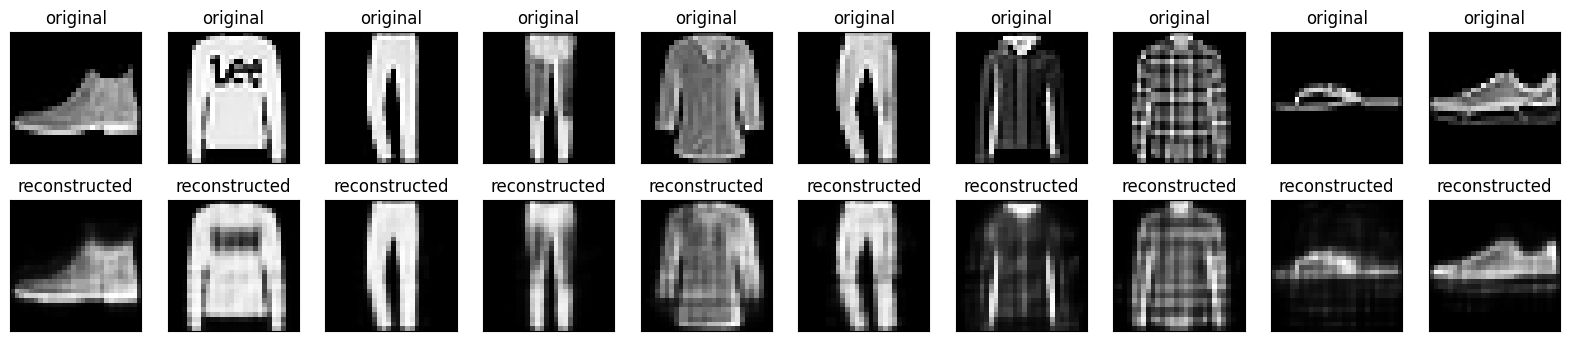

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 2番目の例：画像のノイズ除去

![Image denoising results](images/image_denoise_fmnist_results.png)

オートエンコーダは、画像からノイズを除去するようにトレーニングすることもできます。 次のセクションでは、各画像にランダムノイズを適用して、ノイズの多いバージョンの FashionMNIST データセットを作成します。次に、ノイズの多い画像を入力として使用し、元の画像をターゲットとして使用して、オートエンコーダーをトレーニングします。

データセットを再インポートして、以前に行った変更を省略しましょう。

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


画像にランダムノイズを追加します

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

ノイズの多い画像をプロットします。


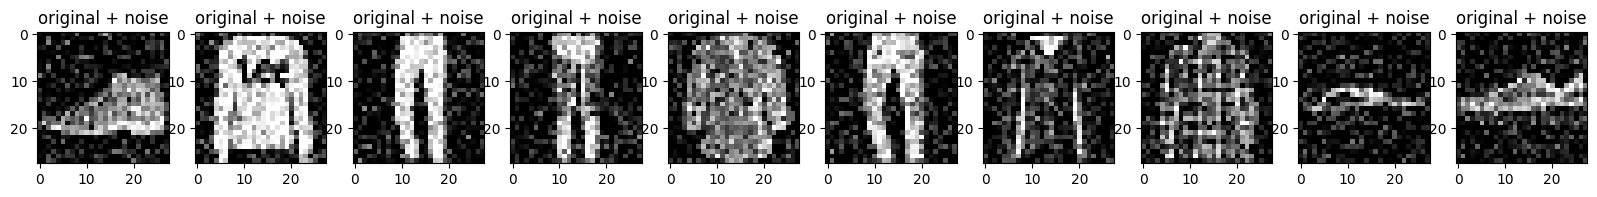

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 畳み込みオートエンコーダーを定義します。

この例では、`encoder` の [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) レイヤーと、`decoder` の [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) レイヤーを使用して畳み込みオートエンコーダーをトレーニングします。

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 1:24:11 - loss: 0.1601

  15/1875 [..............................] - ETA: 6s - loss: 0.1652     

  31/1875 [..............................] - ETA: 6s - loss: 0.1573

  46/1875 [..............................] - ETA: 6s - loss: 0.1472

  62/1875 [..............................] - ETA: 6s - loss: 0.1322

  78/1875 [>.............................] - ETA: 6s - loss: 0.1199

  94/1875 [>.............................] - ETA: 5s - loss: 0.1091

 110/1875 [>.............................] - ETA: 5s - loss: 0.1001

 126/1875 [=>............................] - ETA: 5s - loss: 0.0931

 142/1875 [=>............................] - ETA: 5s - loss: 0.0866

 157/1875 [=>............................] - ETA: 5s - loss: 0.0808

 172/1875 [=>............................] - ETA: 5s - loss: 0.0757

 188/1875 [==>...........................] - ETA: 5s - loss: 0.0711

 204/1875 [==>...........................] - ETA: 5s - loss: 0.0670

 220/1875 [==>...........................] - ETA: 5s - loss: 0.0635

 236/1875 [==>...........................] - ETA: 5s - loss: 0.0604

 251/1875 [===>..........................] - ETA: 5s - loss: 0.0579

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0554

 283/1875 [===>..........................] - ETA: 5s - loss: 0.0532

 299/1875 [===>..........................] - ETA: 5s - loss: 0.0513

 315/1875 [====>.........................] - ETA: 5s - loss: 0.0495

 330/1875 [====>.........................] - ETA: 5s - loss: 0.0479

 346/1875 [====>.........................] - ETA: 5s - loss: 0.0464

 361/1875 [====>.........................] - ETA: 4s - loss: 0.0451

 377/1875 [=====>........................] - ETA: 4s - loss: 0.0438

 393/1875 [=====>........................] - ETA: 4s - loss: 0.0426

 409/1875 [=====>........................] - ETA: 4s - loss: 0.0415

 425/1875 [=====>........................] - ETA: 4s - loss: 0.0405

 441/1875 [======>.......................] - ETA: 4s - loss: 0.0395

 457/1875 [======>.......................] - ETA: 4s - loss: 0.0386

 473/1875 [======>.......................] - ETA: 4s - loss: 0.0377

 489/1875 [======>.......................] - ETA: 4s - loss: 0.0369

 505/1875 [=======>......................] - ETA: 4s - loss: 0.0362

 521/1875 [=======>......................] - ETA: 4s - loss: 0.0355

 537/1875 [=======>......................] - ETA: 4s - loss: 0.0348

 553/1875 [=======>......................] - ETA: 4s - loss: 0.0342

 568/1875 [========>.....................] - ETA: 4s - loss: 0.0336

 583/1875 [========>.....................] - ETA: 4s - loss: 0.0331

 599/1875 [========>.....................] - ETA: 4s - loss: 0.0325

 614/1875 [========>.....................] - ETA: 4s - loss: 0.0320

 629/1875 [=========>....................] - ETA: 4s - loss: 0.0316

 644/1875 [=========>....................] - ETA: 4s - loss: 0.0311

 659/1875 [=========>....................] - ETA: 4s - loss: 0.0307

 675/1875 [=========>....................] - ETA: 3s - loss: 0.0302

 691/1875 [==========>...................] - ETA: 3s - loss: 0.0298

 707/1875 [==========>...................] - ETA: 3s - loss: 0.0294

 723/1875 [==========>...................] - ETA: 3s - loss: 0.0290

 739/1875 [==========>...................] - ETA: 3s - loss: 0.0287

 755/1875 [===========>..................] - ETA: 3s - loss: 0.0283

 771/1875 [===========>..................] - ETA: 3s - loss: 0.0280

 787/1875 [===========>..................] - ETA: 3s - loss: 0.0276

 803/1875 [===========>..................] - ETA: 3s - loss: 0.0273

 819/1875 [============>.................] - ETA: 3s - loss: 0.0270

 835/1875 [============>.................] - ETA: 3s - loss: 0.0267

 851/1875 [============>.................] - ETA: 3s - loss: 0.0265

 867/1875 [============>.................] - ETA: 3s - loss: 0.0262

 883/1875 [=============>................] - ETA: 3s - loss: 0.0259

 899/1875 [=============>................] - ETA: 3s - loss: 0.0257

 915/1875 [=============>................] - ETA: 3s - loss: 0.0254

 931/1875 [=============>................] - ETA: 3s - loss: 0.0252

 947/1875 [==============>...............] - ETA: 3s - loss: 0.0250

 963/1875 [==============>...............] - ETA: 2s - loss: 0.0247

 978/1875 [==============>...............] - ETA: 2s - loss: 0.0245

 994/1875 [==============>...............] - ETA: 2s - loss: 0.0243

1010/1875 [===============>..............] - ETA: 2s - loss: 0.0241

1026/1875 [===============>..............] - ETA: 2s - loss: 0.0239

1042/1875 [===============>..............] - ETA: 2s - loss: 0.0237

1058/1875 [===============>..............] - ETA: 2s - loss: 0.0236

1074/1875 [================>.............] - ETA: 2s - loss: 0.0234

1090/1875 [================>.............] - ETA: 2s - loss: 0.0232

1106/1875 [================>.............] - ETA: 2s - loss: 0.0230

1122/1875 [================>.............] - ETA: 2s - loss: 0.0229

1138/1875 [=================>............] - ETA: 2s - loss: 0.0227

1154/1875 [=================>............] - ETA: 2s - loss: 0.0226

1170/1875 [=================>............] - ETA: 2s - loss: 0.0224

1186/1875 [=================>............] - ETA: 2s - loss: 0.0223

1202/1875 [==================>...........] - ETA: 2s - loss: 0.0221

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0220

1234/1875 [==================>...........] - ETA: 2s - loss: 0.0218

1250/1875 [===================>..........] - ETA: 2s - loss: 0.0217

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0216

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0214

1298/1875 [===================>..........] - ETA: 1s - loss: 0.0213

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0212

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0211

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0209

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0208

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0207

1394/1875 [=====================>........] - ETA: 1s - loss: 0.0206

1410/1875 [=====================>........] - ETA: 1s - loss: 0.0205

1426/1875 [=====================>........] - ETA: 1s - loss: 0.0204

1442/1875 [======================>.......] - ETA: 1s - loss: 0.0203

1458/1875 [======================>.......] - ETA: 1s - loss: 0.0202

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0201

1490/1875 [======================>.......] - ETA: 1s - loss: 0.0200

1506/1875 [=======================>......] - ETA: 1s - loss: 0.0199

1522/1875 [=======================>......] - ETA: 1s - loss: 0.0198

1537/1875 [=======================>......] - ETA: 1s - loss: 0.0197

1552/1875 [=======================>......] - ETA: 1s - loss: 0.0196

1567/1875 [========================>.....] - ETA: 1s - loss: 0.0195

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0194

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0194

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0193

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0192

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0191

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0190

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0189

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0189

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0188

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0187

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0186

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0186

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0185

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0184

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0184

1823/1875 [============================>.] - ETA: 0s - loss: 0.0183

1839/1875 [============================>.] - ETA: 0s - loss: 0.0182

1855/1875 [============================>.] - ETA: 0s - loss: 0.0181

1871/1875 [============================>.] - ETA: 0s - loss: 0.0181

1875/1875 [==============================] - 10s 4ms/step - loss: 0.0181 - val_loss: 0.0105


Epoch 2/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0105

  17/1875 [..............................] - ETA: 6s - loss: 0.0103

  33/1875 [..............................] - ETA: 5s - loss: 0.0103

  49/1875 [..............................] - ETA: 5s - loss: 0.0103

  66/1875 [>.............................] - ETA: 5s - loss: 0.0104

  82/1875 [>.............................] - ETA: 5s - loss: 0.0104

  99/1875 [>.............................] - ETA: 5s - loss: 0.0104

 115/1875 [>.............................] - ETA: 5s - loss: 0.0104

 131/1875 [=>............................] - ETA: 5s - loss: 0.0104

 147/1875 [=>............................] - ETA: 5s - loss: 0.0104

 163/1875 [=>............................] - ETA: 5s - loss: 0.0103

 179/1875 [=>............................] - ETA: 5s - loss: 0.0104

 195/1875 [==>...........................] - ETA: 5s - loss: 0.0103

 211/1875 [==>...........................] - ETA: 5s - loss: 0.0103

 227/1875 [==>...........................] - ETA: 5s - loss: 0.0103

 243/1875 [==>...........................] - ETA: 5s - loss: 0.0103

 258/1875 [===>..........................] - ETA: 5s - loss: 0.0103

 273/1875 [===>..........................] - ETA: 5s - loss: 0.0103

 288/1875 [===>..........................] - ETA: 5s - loss: 0.0103

 303/1875 [===>..........................] - ETA: 5s - loss: 0.0102

 318/1875 [====>.........................] - ETA: 5s - loss: 0.0102

 334/1875 [====>.........................] - ETA: 4s - loss: 0.0102

 350/1875 [====>.........................] - ETA: 4s - loss: 0.0102

 366/1875 [====>.........................] - ETA: 4s - loss: 0.0101

 382/1875 [=====>........................] - ETA: 4s - loss: 0.0101

 398/1875 [=====>........................] - ETA: 4s - loss: 0.0101

 414/1875 [=====>........................] - ETA: 4s - loss: 0.0101

 430/1875 [=====>........................] - ETA: 4s - loss: 0.0101

 446/1875 [======>.......................] - ETA: 4s - loss: 0.0101

 462/1875 [======>.......................] - ETA: 4s - loss: 0.0100

 478/1875 [======>.......................] - ETA: 4s - loss: 0.0100

 494/1875 [======>.......................] - ETA: 4s - loss: 0.0100

 510/1875 [=======>......................] - ETA: 4s - loss: 0.0100

 526/1875 [=======>......................] - ETA: 4s - loss: 0.0100

 542/1875 [=======>......................] - ETA: 4s - loss: 0.0100

 558/1875 [=======>......................] - ETA: 4s - loss: 0.0100

 574/1875 [========>.....................] - ETA: 4s - loss: 0.0100

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0100

 606/1875 [========>.....................] - ETA: 4s - loss: 0.0099

 622/1875 [========>.....................] - ETA: 4s - loss: 0.0099

 638/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 653/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 669/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 685/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 701/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 716/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 732/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 748/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 764/1875 [===========>..................] - ETA: 3s - loss: 0.0099

 780/1875 [===========>..................] - ETA: 3s - loss: 0.0099

 796/1875 [===========>..................] - ETA: 3s - loss: 0.0098

 812/1875 [===========>..................] - ETA: 3s - loss: 0.0098

 828/1875 [============>.................] - ETA: 3s - loss: 0.0098

 844/1875 [============>.................] - ETA: 3s - loss: 0.0098

 860/1875 [============>.................] - ETA: 3s - loss: 0.0098

 876/1875 [=============>................] - ETA: 3s - loss: 0.0098

 892/1875 [=============>................] - ETA: 3s - loss: 0.0098

 908/1875 [=============>................] - ETA: 3s - loss: 0.0098

 924/1875 [=============>................] - ETA: 3s - loss: 0.0098

 940/1875 [==============>...............] - ETA: 3s - loss: 0.0098

 956/1875 [==============>...............] - ETA: 2s - loss: 0.0098

 972/1875 [==============>...............] - ETA: 2s - loss: 0.0097

 988/1875 [==============>...............] - ETA: 2s - loss: 0.0097

1004/1875 [===============>..............] - ETA: 2s - loss: 0.0097

1020/1875 [===============>..............] - ETA: 2s - loss: 0.0097

1036/1875 [===============>..............] - ETA: 2s - loss: 0.0097

1052/1875 [===============>..............] - ETA: 2s - loss: 0.0097

1068/1875 [================>.............] - ETA: 2s - loss: 0.0097

1084/1875 [================>.............] - ETA: 2s - loss: 0.0097

1100/1875 [================>.............] - ETA: 2s - loss: 0.0097

1116/1875 [================>.............] - ETA: 2s - loss: 0.0097

1132/1875 [=================>............] - ETA: 2s - loss: 0.0097

1148/1875 [=================>............] - ETA: 2s - loss: 0.0097

1164/1875 [=================>............] - ETA: 2s - loss: 0.0097

1180/1875 [=================>............] - ETA: 2s - loss: 0.0097

1196/1875 [==================>...........] - ETA: 2s - loss: 0.0097

1212/1875 [==================>...........] - ETA: 2s - loss: 0.0096

1228/1875 [==================>...........] - ETA: 2s - loss: 0.0096

1243/1875 [==================>...........] - ETA: 2s - loss: 0.0096

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1387/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1402/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1417/1875 [=====================>........] - ETA: 1s - loss: 0.0095

1433/1875 [=====================>........] - ETA: 1s - loss: 0.0095

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1463/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1478/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1493/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1538/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1824/1875 [============================>.] - ETA: 0s - loss: 0.0094

1840/1875 [============================>.] - ETA: 0s - loss: 0.0094

1856/1875 [============================>.] - ETA: 0s - loss: 0.0094

1872/1875 [============================>.] - ETA: 0s - loss: 0.0094

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - val_loss: 0.0088


Epoch 3/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0083

  17/1875 [..............................] - ETA: 5s - loss: 0.0088

  33/1875 [..............................] - ETA: 5s - loss: 0.0087

  48/1875 [..............................] - ETA: 6s - loss: 0.0087

  63/1875 [>.............................] - ETA: 6s - loss: 0.0087

  78/1875 [>.............................] - ETA: 5s - loss: 0.0086

  93/1875 [>.............................] - ETA: 5s - loss: 0.0086

 109/1875 [>.............................] - ETA: 5s - loss: 0.0086

 125/1875 [=>............................] - ETA: 5s - loss: 0.0087

 141/1875 [=>............................] - ETA: 5s - loss: 0.0087

 157/1875 [=>............................] - ETA: 5s - loss: 0.0087

 173/1875 [=>............................] - ETA: 5s - loss: 0.0087

 189/1875 [==>...........................] - ETA: 5s - loss: 0.0087

 204/1875 [==>...........................] - ETA: 5s - loss: 0.0087

 220/1875 [==>...........................] - ETA: 5s - loss: 0.0087

 236/1875 [==>...........................] - ETA: 5s - loss: 0.0087

 252/1875 [===>..........................] - ETA: 5s - loss: 0.0087

 268/1875 [===>..........................] - ETA: 5s - loss: 0.0087

 284/1875 [===>..........................] - ETA: 5s - loss: 0.0087

 300/1875 [===>..........................] - ETA: 5s - loss: 0.0087

 316/1875 [====>.........................] - ETA: 5s - loss: 0.0087

 332/1875 [====>.........................] - ETA: 5s - loss: 0.0086

 348/1875 [====>.........................] - ETA: 5s - loss: 0.0086

 364/1875 [====>.........................] - ETA: 4s - loss: 0.0086

 380/1875 [=====>........................] - ETA: 4s - loss: 0.0086

 395/1875 [=====>........................] - ETA: 4s - loss: 0.0086

 410/1875 [=====>........................] - ETA: 4s - loss: 0.0086

 426/1875 [=====>........................] - ETA: 4s - loss: 0.0086

 442/1875 [======>.......................] - ETA: 4s - loss: 0.0086

 458/1875 [======>.......................] - ETA: 4s - loss: 0.0086

 474/1875 [======>.......................] - ETA: 4s - loss: 0.0086

 490/1875 [======>.......................] - ETA: 4s - loss: 0.0086

 506/1875 [=======>......................] - ETA: 4s - loss: 0.0086

 522/1875 [=======>......................] - ETA: 4s - loss: 0.0086

 538/1875 [=======>......................] - ETA: 4s - loss: 0.0086

 554/1875 [=======>......................] - ETA: 4s - loss: 0.0086

 571/1875 [========>.....................] - ETA: 4s - loss: 0.0086

 587/1875 [========>.....................] - ETA: 4s - loss: 0.0086

 602/1875 [========>.....................] - ETA: 4s - loss: 0.0086

 618/1875 [========>.....................] - ETA: 4s - loss: 0.0086

 634/1875 [=========>....................] - ETA: 4s - loss: 0.0086

 650/1875 [=========>....................] - ETA: 4s - loss: 0.0086

 666/1875 [=========>....................] - ETA: 3s - loss: 0.0086

 682/1875 [=========>....................] - ETA: 3s - loss: 0.0086

 697/1875 [==========>...................] - ETA: 3s - loss: 0.0086

 712/1875 [==========>...................] - ETA: 3s - loss: 0.0086

 727/1875 [==========>...................] - ETA: 3s - loss: 0.0086

 743/1875 [==========>...................] - ETA: 3s - loss: 0.0086

 758/1875 [===========>..................] - ETA: 3s - loss: 0.0086

 774/1875 [===========>..................] - ETA: 3s - loss: 0.0086

 790/1875 [===========>..................] - ETA: 3s - loss: 0.0086

 806/1875 [===========>..................] - ETA: 3s - loss: 0.0086

 822/1875 [============>.................] - ETA: 3s - loss: 0.0086

 838/1875 [============>.................] - ETA: 3s - loss: 0.0086

 854/1875 [============>.................] - ETA: 3s - loss: 0.0086

 870/1875 [============>.................] - ETA: 3s - loss: 0.0086

 886/1875 [=============>................] - ETA: 3s - loss: 0.0086

 902/1875 [=============>................] - ETA: 3s - loss: 0.0086

 917/1875 [=============>................] - ETA: 3s - loss: 0.0086

 932/1875 [=============>................] - ETA: 3s - loss: 0.0086

 947/1875 [==============>...............] - ETA: 3s - loss: 0.0086

 962/1875 [==============>...............] - ETA: 3s - loss: 0.0086

 978/1875 [==============>...............] - ETA: 2s - loss: 0.0086

 994/1875 [==============>...............] - ETA: 2s - loss: 0.0086

1010/1875 [===============>..............] - ETA: 2s - loss: 0.0085

1025/1875 [===============>..............] - ETA: 2s - loss: 0.0085

1041/1875 [===============>..............] - ETA: 2s - loss: 0.0085

1057/1875 [===============>..............] - ETA: 2s - loss: 0.0085

1073/1875 [================>.............] - ETA: 2s - loss: 0.0085

1089/1875 [================>.............] - ETA: 2s - loss: 0.0085

1105/1875 [================>.............] - ETA: 2s - loss: 0.0085

1120/1875 [================>.............] - ETA: 2s - loss: 0.0085

1136/1875 [=================>............] - ETA: 2s - loss: 0.0085

1152/1875 [=================>............] - ETA: 2s - loss: 0.0085

1168/1875 [=================>............] - ETA: 2s - loss: 0.0085

1184/1875 [=================>............] - ETA: 2s - loss: 0.0085

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0085

1216/1875 [==================>...........] - ETA: 2s - loss: 0.0085

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0085

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0085

1263/1875 [===================>..........] - ETA: 2s - loss: 0.0085

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0085

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0085

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0085

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0085

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0085

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0085

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0085

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1401/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1417/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0085

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1464/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1479/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1495/1875 [======================>.......] - ETA: 1s - loss: 0.0085

1511/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1557/1875 [=======================>......] - ETA: 1s - loss: 0.0085

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0084

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0084

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0084

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0084

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0084

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0084

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0084

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0084

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0084

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0084

1826/1875 [============================>.] - ETA: 0s - loss: 0.0084

1842/1875 [============================>.] - ETA: 0s - loss: 0.0084

1858/1875 [============================>.] - ETA: 0s - loss: 0.0084

1874/1875 [============================>.] - ETA: 0s - loss: 0.0084

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0084 - val_loss: 0.0082


Epoch 4/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0090

  17/1875 [..............................] - ETA: 5s - loss: 0.0083

  33/1875 [..............................] - ETA: 5s - loss: 0.0082

  49/1875 [..............................] - ETA: 5s - loss: 0.0083

  65/1875 [>.............................] - ETA: 5s - loss: 0.0083

  81/1875 [>.............................] - ETA: 5s - loss: 0.0083

  97/1875 [>.............................] - ETA: 5s - loss: 0.0082

 113/1875 [>.............................] - ETA: 5s - loss: 0.0082

 128/1875 [=>............................] - ETA: 5s - loss: 0.0082

 143/1875 [=>............................] - ETA: 5s - loss: 0.0082

 159/1875 [=>............................] - ETA: 5s - loss: 0.0082

 175/1875 [=>............................] - ETA: 5s - loss: 0.0081

 190/1875 [==>...........................] - ETA: 5s - loss: 0.0081

 206/1875 [==>...........................] - ETA: 5s - loss: 0.0081

 221/1875 [==>...........................] - ETA: 5s - loss: 0.0081

 236/1875 [==>...........................] - ETA: 5s - loss: 0.0081

 252/1875 [===>..........................] - ETA: 5s - loss: 0.0081

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0081

 283/1875 [===>..........................] - ETA: 5s - loss: 0.0081

 299/1875 [===>..........................] - ETA: 5s - loss: 0.0081

 314/1875 [====>.........................] - ETA: 5s - loss: 0.0081

 329/1875 [====>.........................] - ETA: 5s - loss: 0.0081

 344/1875 [====>.........................] - ETA: 5s - loss: 0.0081

 359/1875 [====>.........................] - ETA: 5s - loss: 0.0081

 374/1875 [====>.........................] - ETA: 4s - loss: 0.0081

 390/1875 [=====>........................] - ETA: 4s - loss: 0.0081

 406/1875 [=====>........................] - ETA: 4s - loss: 0.0081

 421/1875 [=====>........................] - ETA: 4s - loss: 0.0081

 436/1875 [=====>........................] - ETA: 4s - loss: 0.0081

 451/1875 [======>.......................] - ETA: 4s - loss: 0.0081

 466/1875 [======>.......................] - ETA: 4s - loss: 0.0081

 482/1875 [======>.......................] - ETA: 4s - loss: 0.0081

 497/1875 [======>.......................] - ETA: 4s - loss: 0.0081

 513/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 528/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 544/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 559/1875 [=======>......................] - ETA: 4s - loss: 0.0081

 574/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 605/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 620/1875 [========>.....................] - ETA: 4s - loss: 0.0081

 635/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 651/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 666/1875 [=========>....................] - ETA: 4s - loss: 0.0081

 681/1875 [=========>....................] - ETA: 3s - loss: 0.0081

 696/1875 [==========>...................] - ETA: 3s - loss: 0.0081

 712/1875 [==========>...................] - ETA: 3s - loss: 0.0080

 728/1875 [==========>...................] - ETA: 3s - loss: 0.0080

 744/1875 [==========>...................] - ETA: 3s - loss: 0.0080

 760/1875 [===========>..................] - ETA: 3s - loss: 0.0080

 776/1875 [===========>..................] - ETA: 3s - loss: 0.0080

 792/1875 [===========>..................] - ETA: 3s - loss: 0.0080

 808/1875 [===========>..................] - ETA: 3s - loss: 0.0080

 824/1875 [============>.................] - ETA: 3s - loss: 0.0080

 840/1875 [============>.................] - ETA: 3s - loss: 0.0080

 856/1875 [============>.................] - ETA: 3s - loss: 0.0080

 872/1875 [============>.................] - ETA: 3s - loss: 0.0080

 888/1875 [=============>................] - ETA: 3s - loss: 0.0080

 904/1875 [=============>................] - ETA: 3s - loss: 0.0080

 920/1875 [=============>................] - ETA: 3s - loss: 0.0080

 936/1875 [=============>................] - ETA: 3s - loss: 0.0080

 952/1875 [==============>...............] - ETA: 3s - loss: 0.0080

 968/1875 [==============>...............] - ETA: 2s - loss: 0.0080

 984/1875 [==============>...............] - ETA: 2s - loss: 0.0080

1000/1875 [===============>..............] - ETA: 2s - loss: 0.0080

1016/1875 [===============>..............] - ETA: 2s - loss: 0.0080

1032/1875 [===============>..............] - ETA: 2s - loss: 0.0080

1048/1875 [===============>..............] - ETA: 2s - loss: 0.0080

1064/1875 [================>.............] - ETA: 2s - loss: 0.0080

1080/1875 [================>.............] - ETA: 2s - loss: 0.0080

1096/1875 [================>.............] - ETA: 2s - loss: 0.0080

1112/1875 [================>.............] - ETA: 2s - loss: 0.0080

1128/1875 [=================>............] - ETA: 2s - loss: 0.0080

1144/1875 [=================>............] - ETA: 2s - loss: 0.0080

1160/1875 [=================>............] - ETA: 2s - loss: 0.0080

1176/1875 [=================>............] - ETA: 2s - loss: 0.0080

1192/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1208/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1224/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1240/1875 [==================>...........] - ETA: 2s - loss: 0.0080

1256/1875 [===================>..........] - ETA: 2s - loss: 0.0080

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0080

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0080

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0080

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0080

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0080

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0080

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0080

1383/1875 [=====================>........] - ETA: 1s - loss: 0.0080

1398/1875 [=====================>........] - ETA: 1s - loss: 0.0080

1414/1875 [=====================>........] - ETA: 1s - loss: 0.0080

1430/1875 [=====================>........] - ETA: 1s - loss: 0.0080

1446/1875 [======================>.......] - ETA: 1s - loss: 0.0080

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0080

1478/1875 [======================>.......] - ETA: 1s - loss: 0.0080

1494/1875 [======================>.......] - ETA: 1s - loss: 0.0080

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0080

1526/1875 [=======================>......] - ETA: 1s - loss: 0.0080

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0080

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0080

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0080

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0080

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0080

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0080

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0080

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0080

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0080

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0079

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0079

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0079

1828/1875 [============================>.] - ETA: 0s - loss: 0.0079

1844/1875 [============================>.] - ETA: 0s - loss: 0.0079

1860/1875 [============================>.] - ETA: 0s - loss: 0.0079

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0079 - val_loss: 0.0077


Epoch 5/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0078

  17/1875 [..............................] - ETA: 6s - loss: 0.0078

  32/1875 [..............................] - ETA: 6s - loss: 0.0077

  47/1875 [..............................] - ETA: 6s - loss: 0.0077

  63/1875 [>.............................] - ETA: 5s - loss: 0.0077

  79/1875 [>.............................] - ETA: 5s - loss: 0.0077

  95/1875 [>.............................] - ETA: 5s - loss: 0.0077

 111/1875 [>.............................] - ETA: 5s - loss: 0.0077

 127/1875 [=>............................] - ETA: 5s - loss: 0.0077

 142/1875 [=>............................] - ETA: 5s - loss: 0.0077

 158/1875 [=>............................] - ETA: 5s - loss: 0.0077

 173/1875 [=>............................] - ETA: 5s - loss: 0.0077

 189/1875 [==>...........................] - ETA: 5s - loss: 0.0077

 204/1875 [==>...........................] - ETA: 5s - loss: 0.0077

 219/1875 [==>...........................] - ETA: 5s - loss: 0.0077

 235/1875 [==>...........................] - ETA: 5s - loss: 0.0077

 251/1875 [===>..........................] - ETA: 5s - loss: 0.0077

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0077

 283/1875 [===>..........................] - ETA: 5s - loss: 0.0077

 299/1875 [===>..........................] - ETA: 5s - loss: 0.0077

 315/1875 [====>.........................] - ETA: 5s - loss: 0.0077

 331/1875 [====>.........................] - ETA: 5s - loss: 0.0077

 347/1875 [====>.........................] - ETA: 5s - loss: 0.0077

 363/1875 [====>.........................] - ETA: 4s - loss: 0.0077

 379/1875 [=====>........................] - ETA: 4s - loss: 0.0076

 395/1875 [=====>........................] - ETA: 4s - loss: 0.0076

 411/1875 [=====>........................] - ETA: 4s - loss: 0.0076

 427/1875 [=====>........................] - ETA: 4s - loss: 0.0076

 443/1875 [======>.......................] - ETA: 4s - loss: 0.0076

 459/1875 [======>.......................] - ETA: 4s - loss: 0.0076

 475/1875 [======>.......................] - ETA: 4s - loss: 0.0076

 491/1875 [======>.......................] - ETA: 4s - loss: 0.0076

 507/1875 [=======>......................] - ETA: 4s - loss: 0.0076

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0076

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0076

 555/1875 [=======>......................] - ETA: 4s - loss: 0.0076

 571/1875 [========>.....................] - ETA: 4s - loss: 0.0076

 587/1875 [========>.....................] - ETA: 4s - loss: 0.0076

 603/1875 [========>.....................] - ETA: 4s - loss: 0.0076

 619/1875 [========>.....................] - ETA: 4s - loss: 0.0076

 635/1875 [=========>....................] - ETA: 4s - loss: 0.0076

 651/1875 [=========>....................] - ETA: 3s - loss: 0.0076

 667/1875 [=========>....................] - ETA: 3s - loss: 0.0076

 683/1875 [=========>....................] - ETA: 3s - loss: 0.0076

 699/1875 [==========>...................] - ETA: 3s - loss: 0.0076

 715/1875 [==========>...................] - ETA: 3s - loss: 0.0076

 731/1875 [==========>...................] - ETA: 3s - loss: 0.0076

 747/1875 [==========>...................] - ETA: 3s - loss: 0.0076

 763/1875 [===========>..................] - ETA: 3s - loss: 0.0076

 779/1875 [===========>..................] - ETA: 3s - loss: 0.0076

 795/1875 [===========>..................] - ETA: 3s - loss: 0.0076

 811/1875 [===========>..................] - ETA: 3s - loss: 0.0076

 827/1875 [============>.................] - ETA: 3s - loss: 0.0076

 843/1875 [============>.................] - ETA: 3s - loss: 0.0076

 859/1875 [============>.................] - ETA: 3s - loss: 0.0076

 875/1875 [=============>................] - ETA: 3s - loss: 0.0076

 891/1875 [=============>................] - ETA: 3s - loss: 0.0076

 907/1875 [=============>................] - ETA: 3s - loss: 0.0076

 923/1875 [=============>................] - ETA: 3s - loss: 0.0076

 939/1875 [==============>...............] - ETA: 3s - loss: 0.0076

 955/1875 [==============>...............] - ETA: 2s - loss: 0.0076

 971/1875 [==============>...............] - ETA: 2s - loss: 0.0076

 987/1875 [==============>...............] - ETA: 2s - loss: 0.0076

1003/1875 [===============>..............] - ETA: 2s - loss: 0.0076

1019/1875 [===============>..............] - ETA: 2s - loss: 0.0076

1035/1875 [===============>..............] - ETA: 2s - loss: 0.0076

1051/1875 [===============>..............] - ETA: 2s - loss: 0.0076

1067/1875 [================>.............] - ETA: 2s - loss: 0.0076

1083/1875 [================>.............] - ETA: 2s - loss: 0.0076

1100/1875 [================>.............] - ETA: 2s - loss: 0.0076

1117/1875 [================>.............] - ETA: 2s - loss: 0.0076

1134/1875 [=================>............] - ETA: 2s - loss: 0.0076

1150/1875 [=================>............] - ETA: 2s - loss: 0.0076

1166/1875 [=================>............] - ETA: 2s - loss: 0.0076

1183/1875 [=================>............] - ETA: 2s - loss: 0.0076

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1217/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1233/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1249/1875 [==================>...........] - ETA: 2s - loss: 0.0075

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0075

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0075

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0075

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1331/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0075

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1412/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1428/1875 [=====================>........] - ETA: 1s - loss: 0.0075

1444/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1476/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1493/1875 [======================>.......] - ETA: 1s - loss: 0.0075

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1526/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0075

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0075

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0075

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0075

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0075

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0075

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0075

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0075

1816/1875 [============================>.] - ETA: 0s - loss: 0.0075

1832/1875 [============================>.] - ETA: 0s - loss: 0.0075

1848/1875 [============================>.] - ETA: 0s - loss: 0.0075

1864/1875 [============================>.] - ETA: 0s - loss: 0.0075

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0075 - val_loss: 0.0074


Epoch 6/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0067

  17/1875 [..............................] - ETA: 6s - loss: 0.0073

  33/1875 [..............................] - ETA: 5s - loss: 0.0072

  49/1875 [..............................] - ETA: 5s - loss: 0.0073

  66/1875 [>.............................] - ETA: 5s - loss: 0.0073

  83/1875 [>.............................] - ETA: 5s - loss: 0.0073

 100/1875 [>.............................] - ETA: 5s - loss: 0.0073

 117/1875 [>.............................] - ETA: 5s - loss: 0.0073

 133/1875 [=>............................] - ETA: 5s - loss: 0.0073

 150/1875 [=>............................] - ETA: 5s - loss: 0.0073

 166/1875 [=>............................] - ETA: 5s - loss: 0.0073

 182/1875 [=>............................] - ETA: 5s - loss: 0.0073

 199/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 216/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 233/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 250/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 284/1875 [===>..........................] - ETA: 4s - loss: 0.0073

 301/1875 [===>..........................] - ETA: 4s - loss: 0.0073

 318/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 334/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 350/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 366/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 382/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 398/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 414/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 431/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 447/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 464/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 481/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 498/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 514/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 531/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 565/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 582/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 599/1875 [========>.....................] - ETA: 3s - loss: 0.0073

 616/1875 [========>.....................] - ETA: 3s - loss: 0.0073

 633/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 650/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 667/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 683/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 700/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 717/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 734/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 751/1875 [===========>..................] - ETA: 3s - loss: 0.0073

 768/1875 [===========>..................] - ETA: 3s - loss: 0.0073

 785/1875 [===========>..................] - ETA: 3s - loss: 0.0073

 802/1875 [===========>..................] - ETA: 3s - loss: 0.0073

 819/1875 [============>.................] - ETA: 3s - loss: 0.0073

 836/1875 [============>.................] - ETA: 3s - loss: 0.0073

 853/1875 [============>.................] - ETA: 3s - loss: 0.0073

 870/1875 [============>.................] - ETA: 3s - loss: 0.0073

 887/1875 [=============>................] - ETA: 3s - loss: 0.0073

 904/1875 [=============>................] - ETA: 2s - loss: 0.0073

 920/1875 [=============>................] - ETA: 2s - loss: 0.0073

 936/1875 [=============>................] - ETA: 2s - loss: 0.0073

 952/1875 [==============>...............] - ETA: 2s - loss: 0.0073

 968/1875 [==============>...............] - ETA: 2s - loss: 0.0073

 984/1875 [==============>...............] - ETA: 2s - loss: 0.0073

1001/1875 [===============>..............] - ETA: 2s - loss: 0.0073

1018/1875 [===============>..............] - ETA: 2s - loss: 0.0073

1035/1875 [===============>..............] - ETA: 2s - loss: 0.0073

1051/1875 [===============>..............] - ETA: 2s - loss: 0.0073

1068/1875 [================>.............] - ETA: 2s - loss: 0.0073

1085/1875 [================>.............] - ETA: 2s - loss: 0.0073

1102/1875 [================>.............] - ETA: 2s - loss: 0.0073

1119/1875 [================>.............] - ETA: 2s - loss: 0.0073

1136/1875 [=================>............] - ETA: 2s - loss: 0.0073

1153/1875 [=================>............] - ETA: 2s - loss: 0.0073

1169/1875 [=================>............] - ETA: 2s - loss: 0.0073

1186/1875 [=================>............] - ETA: 2s - loss: 0.0073

1203/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0073

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0073

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0073

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0073

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0073

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0073

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0073

1387/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1421/1875 [=====================>........] - ETA: 1s - loss: 0.0073

1438/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1455/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1472/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1489/1875 [======================>.......] - ETA: 1s - loss: 0.0073

1506/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1540/1875 [=======================>......] - ETA: 1s - loss: 0.0073

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0073

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0073

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0073

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0073

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0073

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0073

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0073

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0073

1823/1875 [============================>.] - ETA: 0s - loss: 0.0073

1840/1875 [============================>.] - ETA: 0s - loss: 0.0073

1856/1875 [============================>.] - ETA: 0s - loss: 0.0073

1872/1875 [============================>.] - ETA: 0s - loss: 0.0073

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0073 - val_loss: 0.0074


Epoch 7/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0076

  17/1875 [..............................] - ETA: 5s - loss: 0.0073

  33/1875 [..............................] - ETA: 5s - loss: 0.0072

  49/1875 [..............................] - ETA: 5s - loss: 0.0072

  65/1875 [>.............................] - ETA: 5s - loss: 0.0072

  81/1875 [>.............................] - ETA: 5s - loss: 0.0072

  98/1875 [>.............................] - ETA: 5s - loss: 0.0072

 114/1875 [>.............................] - ETA: 5s - loss: 0.0072

 130/1875 [=>............................] - ETA: 5s - loss: 0.0072

 147/1875 [=>............................] - ETA: 5s - loss: 0.0072

 164/1875 [=>............................] - ETA: 5s - loss: 0.0072

 180/1875 [=>............................] - ETA: 5s - loss: 0.0072

 196/1875 [==>...........................] - ETA: 5s - loss: 0.0072

 212/1875 [==>...........................] - ETA: 5s - loss: 0.0072

 228/1875 [==>...........................] - ETA: 5s - loss: 0.0072

 244/1875 [==>...........................] - ETA: 5s - loss: 0.0072

 260/1875 [===>..........................] - ETA: 5s - loss: 0.0072

 276/1875 [===>..........................] - ETA: 5s - loss: 0.0072

 293/1875 [===>..........................] - ETA: 4s - loss: 0.0072

 309/1875 [===>..........................] - ETA: 4s - loss: 0.0072

 325/1875 [====>.........................] - ETA: 4s - loss: 0.0072

 341/1875 [====>.........................] - ETA: 4s - loss: 0.0072

 357/1875 [====>.........................] - ETA: 4s - loss: 0.0072

 373/1875 [====>.........................] - ETA: 4s - loss: 0.0072

 389/1875 [=====>........................] - ETA: 4s - loss: 0.0072

 405/1875 [=====>........................] - ETA: 4s - loss: 0.0072

 421/1875 [=====>........................] - ETA: 4s - loss: 0.0072

 437/1875 [=====>........................] - ETA: 4s - loss: 0.0072

 453/1875 [======>.......................] - ETA: 4s - loss: 0.0072

 469/1875 [======>.......................] - ETA: 4s - loss: 0.0072

 485/1875 [======>.......................] - ETA: 4s - loss: 0.0072

 501/1875 [=======>......................] - ETA: 4s - loss: 0.0072

 517/1875 [=======>......................] - ETA: 4s - loss: 0.0072

 532/1875 [=======>......................] - ETA: 4s - loss: 0.0072

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0072

 565/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 581/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 597/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 613/1875 [========>.....................] - ETA: 4s - loss: 0.0072

 629/1875 [=========>....................] - ETA: 3s - loss: 0.0072

 645/1875 [=========>....................] - ETA: 3s - loss: 0.0072

 661/1875 [=========>....................] - ETA: 3s - loss: 0.0072

 677/1875 [=========>....................] - ETA: 3s - loss: 0.0072

 693/1875 [==========>...................] - ETA: 3s - loss: 0.0072

 709/1875 [==========>...................] - ETA: 3s - loss: 0.0072

 724/1875 [==========>...................] - ETA: 3s - loss: 0.0072

 739/1875 [==========>...................] - ETA: 3s - loss: 0.0072

 754/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 770/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 786/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 802/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 818/1875 [============>.................] - ETA: 3s - loss: 0.0072

 834/1875 [============>.................] - ETA: 3s - loss: 0.0072

 850/1875 [============>.................] - ETA: 3s - loss: 0.0072

 866/1875 [============>.................] - ETA: 3s - loss: 0.0072

 882/1875 [=============>................] - ETA: 3s - loss: 0.0072

 898/1875 [=============>................] - ETA: 3s - loss: 0.0072

 914/1875 [=============>................] - ETA: 3s - loss: 0.0071

 930/1875 [=============>................] - ETA: 3s - loss: 0.0071

 946/1875 [==============>...............] - ETA: 2s - loss: 0.0072

 962/1875 [==============>...............] - ETA: 2s - loss: 0.0072

 978/1875 [==============>...............] - ETA: 2s - loss: 0.0072

 994/1875 [==============>...............] - ETA: 2s - loss: 0.0071

1010/1875 [===============>..............] - ETA: 2s - loss: 0.0071

1026/1875 [===============>..............] - ETA: 2s - loss: 0.0071

1042/1875 [===============>..............] - ETA: 2s - loss: 0.0072

1058/1875 [===============>..............] - ETA: 2s - loss: 0.0072

1074/1875 [================>.............] - ETA: 2s - loss: 0.0071

1090/1875 [================>.............] - ETA: 2s - loss: 0.0071

1106/1875 [================>.............] - ETA: 2s - loss: 0.0071

1122/1875 [================>.............] - ETA: 2s - loss: 0.0071

1138/1875 [=================>............] - ETA: 2s - loss: 0.0071

1154/1875 [=================>............] - ETA: 2s - loss: 0.0071

1170/1875 [=================>............] - ETA: 2s - loss: 0.0071

1187/1875 [=================>............] - ETA: 2s - loss: 0.0071

1203/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1219/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1235/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1251/1875 [===================>..........] - ETA: 1s - loss: 0.0071

1268/1875 [===================>..........] - ETA: 1s - loss: 0.0071

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0071

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0071

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0071

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1412/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0071

1446/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1478/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1494/1875 [======================>.......] - ETA: 1s - loss: 0.0071

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1544/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1561/1875 [=======================>......] - ETA: 1s - loss: 0.0071

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0071

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0071

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0071

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0071

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0071

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0071

1827/1875 [============================>.] - ETA: 0s - loss: 0.0071

1844/1875 [============================>.] - ETA: 0s - loss: 0.0071

1860/1875 [============================>.] - ETA: 0s - loss: 0.0071

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0071 - val_loss: 0.0071


Epoch 8/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0069

  16/1875 [..............................] - ETA: 6s - loss: 0.0073

  31/1875 [..............................] - ETA: 6s - loss: 0.0071

  47/1875 [..............................] - ETA: 6s - loss: 0.0071

  63/1875 [>.............................] - ETA: 5s - loss: 0.0070

  79/1875 [>.............................] - ETA: 5s - loss: 0.0070

  95/1875 [>.............................] - ETA: 5s - loss: 0.0070

 112/1875 [>.............................] - ETA: 5s - loss: 0.0070

 128/1875 [=>............................] - ETA: 5s - loss: 0.0070

 144/1875 [=>............................] - ETA: 5s - loss: 0.0070

 160/1875 [=>............................] - ETA: 5s - loss: 0.0070

 176/1875 [=>............................] - ETA: 5s - loss: 0.0070

 192/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 208/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 224/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 240/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 256/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 273/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 289/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 305/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 321/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 337/1875 [====>.........................] - ETA: 4s - loss: 0.0071

 353/1875 [====>.........................] - ETA: 4s - loss: 0.0071

 369/1875 [====>.........................] - ETA: 4s - loss: 0.0071

 385/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 401/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 417/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 433/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 449/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 465/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 481/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 497/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 513/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 529/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 545/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 561/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 577/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 593/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 609/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 625/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 641/1875 [=========>....................] - ETA: 3s - loss: 0.0071

 657/1875 [=========>....................] - ETA: 3s - loss: 0.0071

 672/1875 [=========>....................] - ETA: 3s - loss: 0.0071

 688/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 704/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 720/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 736/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 752/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 768/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 784/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 816/1875 [============>.................] - ETA: 3s - loss: 0.0071

 831/1875 [============>.................] - ETA: 3s - loss: 0.0071

 847/1875 [============>.................] - ETA: 3s - loss: 0.0071

 863/1875 [============>.................] - ETA: 3s - loss: 0.0071

 879/1875 [=============>................] - ETA: 3s - loss: 0.0071

 895/1875 [=============>................] - ETA: 3s - loss: 0.0071

 910/1875 [=============>................] - ETA: 3s - loss: 0.0071

 926/1875 [=============>................] - ETA: 3s - loss: 0.0071

 942/1875 [==============>...............] - ETA: 3s - loss: 0.0071

 957/1875 [==============>...............] - ETA: 2s - loss: 0.0071

 973/1875 [==============>...............] - ETA: 2s - loss: 0.0071

 989/1875 [==============>...............] - ETA: 2s - loss: 0.0071

1005/1875 [===============>..............] - ETA: 2s - loss: 0.0071

1021/1875 [===============>..............] - ETA: 2s - loss: 0.0071

1037/1875 [===============>..............] - ETA: 2s - loss: 0.0071

1052/1875 [===============>..............] - ETA: 2s - loss: 0.0071

1068/1875 [================>.............] - ETA: 2s - loss: 0.0071

1084/1875 [================>.............] - ETA: 2s - loss: 0.0071

1100/1875 [================>.............] - ETA: 2s - loss: 0.0071

1116/1875 [================>.............] - ETA: 2s - loss: 0.0071

1132/1875 [=================>............] - ETA: 2s - loss: 0.0071

1147/1875 [=================>............] - ETA: 2s - loss: 0.0071

1163/1875 [=================>............] - ETA: 2s - loss: 0.0071

1178/1875 [=================>............] - ETA: 2s - loss: 0.0071

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1210/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0071

1241/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1256/1875 [===================>..........] - ETA: 2s - loss: 0.0070

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1367/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1383/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1399/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1415/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1431/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1447/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1477/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1492/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1524/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1540/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1556/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1823/1875 [============================>.] - ETA: 0s - loss: 0.0070

1839/1875 [============================>.] - ETA: 0s - loss: 0.0070

1855/1875 [============================>.] - ETA: 0s - loss: 0.0070

1871/1875 [============================>.] - ETA: 0s - loss: 0.0070

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - val_loss: 0.0070


Epoch 9/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0068

  17/1875 [..............................] - ETA: 6s - loss: 0.0069

  34/1875 [..............................] - ETA: 5s - loss: 0.0070

  50/1875 [..............................] - ETA: 5s - loss: 0.0070

  66/1875 [>.............................] - ETA: 5s - loss: 0.0070

  82/1875 [>.............................] - ETA: 5s - loss: 0.0070

  98/1875 [>.............................] - ETA: 5s - loss: 0.0069

 113/1875 [>.............................] - ETA: 5s - loss: 0.0069

 129/1875 [=>............................] - ETA: 5s - loss: 0.0069

 145/1875 [=>............................] - ETA: 5s - loss: 0.0069

 161/1875 [=>............................] - ETA: 5s - loss: 0.0069

 178/1875 [=>............................] - ETA: 5s - loss: 0.0069

 195/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 212/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 228/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 243/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 258/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 273/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 288/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 304/1875 [===>..........................] - ETA: 5s - loss: 0.0070

 320/1875 [====>.........................] - ETA: 5s - loss: 0.0070

 336/1875 [====>.........................] - ETA: 4s - loss: 0.0070

 352/1875 [====>.........................] - ETA: 4s - loss: 0.0070

 368/1875 [====>.........................] - ETA: 4s - loss: 0.0070

 384/1875 [=====>........................] - ETA: 4s - loss: 0.0070

 400/1875 [=====>........................] - ETA: 4s - loss: 0.0070

 416/1875 [=====>........................] - ETA: 4s - loss: 0.0070

 432/1875 [=====>........................] - ETA: 4s - loss: 0.0070

 449/1875 [======>.......................] - ETA: 4s - loss: 0.0070

 465/1875 [======>.......................] - ETA: 4s - loss: 0.0070

 481/1875 [======>.......................] - ETA: 4s - loss: 0.0070

 497/1875 [======>.......................] - ETA: 4s - loss: 0.0070

 514/1875 [=======>......................] - ETA: 4s - loss: 0.0070

 531/1875 [=======>......................] - ETA: 4s - loss: 0.0070

 547/1875 [=======>......................] - ETA: 4s - loss: 0.0070

 563/1875 [========>.....................] - ETA: 4s - loss: 0.0070

 579/1875 [========>.....................] - ETA: 4s - loss: 0.0070

 595/1875 [========>.....................] - ETA: 4s - loss: 0.0070

 611/1875 [========>.....................] - ETA: 4s - loss: 0.0070

 628/1875 [=========>....................] - ETA: 3s - loss: 0.0070

 644/1875 [=========>....................] - ETA: 3s - loss: 0.0070

 661/1875 [=========>....................] - ETA: 3s - loss: 0.0070

 677/1875 [=========>....................] - ETA: 3s - loss: 0.0070

 694/1875 [==========>...................] - ETA: 3s - loss: 0.0070

 710/1875 [==========>...................] - ETA: 3s - loss: 0.0070

 726/1875 [==========>...................] - ETA: 3s - loss: 0.0070

 742/1875 [==========>...................] - ETA: 3s - loss: 0.0070

 758/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 775/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 792/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 809/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 826/1875 [============>.................] - ETA: 3s - loss: 0.0070

 843/1875 [============>.................] - ETA: 3s - loss: 0.0070

 859/1875 [============>.................] - ETA: 3s - loss: 0.0070

 875/1875 [=============>................] - ETA: 3s - loss: 0.0070

 892/1875 [=============>................] - ETA: 3s - loss: 0.0070

 909/1875 [=============>................] - ETA: 3s - loss: 0.0070

 926/1875 [=============>................] - ETA: 3s - loss: 0.0070

 943/1875 [==============>...............] - ETA: 2s - loss: 0.0070

 960/1875 [==============>...............] - ETA: 2s - loss: 0.0070

 977/1875 [==============>...............] - ETA: 2s - loss: 0.0070

 992/1875 [==============>...............] - ETA: 2s - loss: 0.0070

1008/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1024/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1040/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1056/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1072/1875 [================>.............] - ETA: 2s - loss: 0.0070

1088/1875 [================>.............] - ETA: 2s - loss: 0.0070

1104/1875 [================>.............] - ETA: 2s - loss: 0.0070

1120/1875 [================>.............] - ETA: 2s - loss: 0.0070

1136/1875 [=================>............] - ETA: 2s - loss: 0.0070

1152/1875 [=================>............] - ETA: 2s - loss: 0.0070

1168/1875 [=================>............] - ETA: 2s - loss: 0.0070

1184/1875 [=================>............] - ETA: 2s - loss: 0.0070

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1217/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1233/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1363/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1394/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1410/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1426/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1442/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1459/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1476/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1493/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1510/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1544/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0070

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1825/1875 [============================>.] - ETA: 0s - loss: 0.0070

1841/1875 [============================>.] - ETA: 0s - loss: 0.0070

1857/1875 [============================>.] - ETA: 0s - loss: 0.0070

1874/1875 [============================>.] - ETA: 0s - loss: 0.0070

1875/1875 [==============================] - 7s 3ms/step - loss: 0.0070 - val_loss: 0.0070


Epoch 10/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0071

  17/1875 [..............................] - ETA: 5s - loss: 0.0069

  33/1875 [..............................] - ETA: 5s - loss: 0.0069

  50/1875 [..............................] - ETA: 5s - loss: 0.0069

  67/1875 [>.............................] - ETA: 5s - loss: 0.0070

  84/1875 [>.............................] - ETA: 5s - loss: 0.0069

 101/1875 [>.............................] - ETA: 5s - loss: 0.0069

 118/1875 [>.............................] - ETA: 5s - loss: 0.0069

 135/1875 [=>............................] - ETA: 5s - loss: 0.0069

 152/1875 [=>............................] - ETA: 5s - loss: 0.0069

 169/1875 [=>............................] - ETA: 5s - loss: 0.0069

 185/1875 [=>............................] - ETA: 5s - loss: 0.0069

 202/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 219/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 235/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 251/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 267/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 283/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 299/1875 [===>..........................] - ETA: 4s - loss: 0.0069

 315/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 331/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 347/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 363/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 379/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 395/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 411/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 427/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 443/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 459/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 475/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 491/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 507/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 555/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 571/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 586/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 602/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 618/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 634/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 650/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 666/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 682/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 698/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 714/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 730/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 746/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 762/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 778/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 793/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 809/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 826/1875 [============>.................] - ETA: 3s - loss: 0.0069

 842/1875 [============>.................] - ETA: 3s - loss: 0.0069

 858/1875 [============>.................] - ETA: 3s - loss: 0.0069

 874/1875 [============>.................] - ETA: 3s - loss: 0.0069

 890/1875 [=============>................] - ETA: 3s - loss: 0.0069

 906/1875 [=============>................] - ETA: 3s - loss: 0.0069

 922/1875 [=============>................] - ETA: 3s - loss: 0.0069

 938/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 954/1875 [==============>...............] - ETA: 2s - loss: 0.0069

 970/1875 [==============>...............] - ETA: 2s - loss: 0.0069

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0069

1002/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1018/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1034/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1050/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1066/1875 [================>.............] - ETA: 2s - loss: 0.0069

1082/1875 [================>.............] - ETA: 2s - loss: 0.0069

1098/1875 [================>.............] - ETA: 2s - loss: 0.0069

1114/1875 [================>.............] - ETA: 2s - loss: 0.0069

1130/1875 [=================>............] - ETA: 2s - loss: 0.0069

1146/1875 [=================>............] - ETA: 2s - loss: 0.0069

1162/1875 [=================>............] - ETA: 2s - loss: 0.0069

1177/1875 [=================>............] - ETA: 2s - loss: 0.0069

1193/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1209/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1225/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1241/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1337/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1353/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1369/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1401/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1417/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1433/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1449/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1465/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1481/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1512/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1813/1875 [============================>.] - ETA: 0s - loss: 0.0069

1829/1875 [============================>.] - ETA: 0s - loss: 0.0069

1846/1875 [============================>.] - ETA: 0s - loss: 0.0069

1863/1875 [============================>.] - ETA: 0s - loss: 0.0069

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0069 - val_loss: 0.0069


エンコーダーの概要を見てみましょう。画像が 28x28 から 7x7 にダウンサンプリングされていることに注目してください。

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 14, 14, 16)        160       


 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      


Total params: 1320 (5.16 KB)


Trainable params: 1320 (5.16 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


デコーダーは画像を 7x7 から 28x28 にアップサンプリングします。

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       


 anspose)                                                        


 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      


 Transpose)                                                      


 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       


Total params: 1897 (7.41 KB)


Trainable params: 1897 (7.41 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


オートエンコーダにより生成されたノイズの多い画像とノイズ除去された画像の両方をプロットします。

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

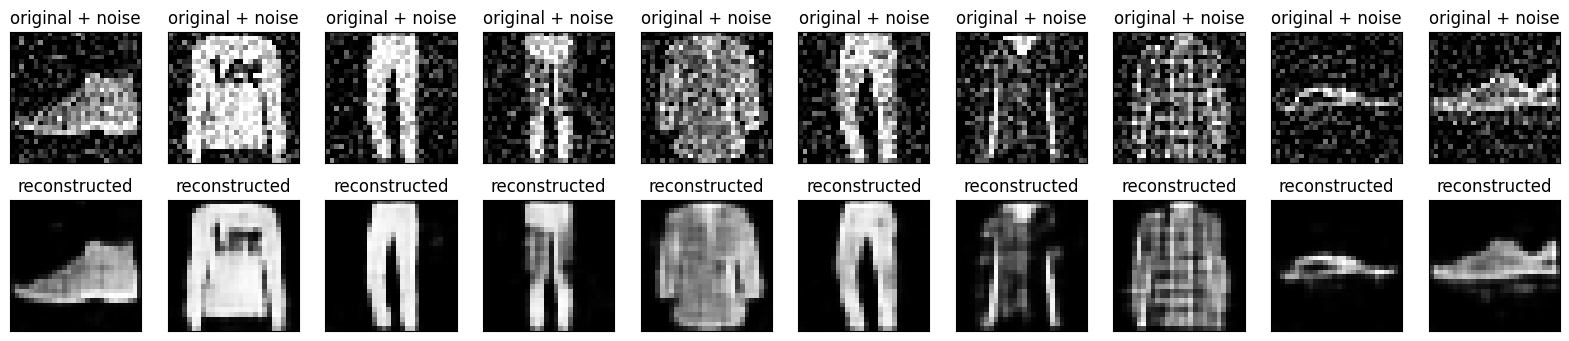

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 3番目の例：異常検出

## 概要

この例では、オートエンコーダーをトレーニングして、[ECG5000 データセット](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)の異常を検出します。このデータセットには、5,000 の[心電図](https://en.wikipedia.org/wiki/Electrocardiography)が含まれ、それぞれに 140 のデータポイントがあります。データセットの簡略化されたバージョンを使用します。各例には、`0`（異常なリズムに対応）または`1`（正常なリズムに対応）のいずれかのラベルが付けられています。ここでは異常なリズムを特定することに興味があります。

注意：これはラベル付きのデータセットであるため、教師あり学習の問題と見なせます。この例の目的は、ラベルが使用できない、より大きなデータセットに適用できる異常検出の概念を説明することです（たとえば、数千の正常なリズムがあり、異常なリズムが少数しかない場合）。

オートエンコーダーを使用すると、どのようにして異常を検出できるのでしょうか？オートエンコーダは、再構築エラーを最小限に抑えるようにトレーニングされていることを思い出してください。オートエンコーダーは通常のリズムでのみトレーニングし、それを使用してすべてのデータを再構築します。私たちの仮説は、異常なリズムはより高い再構成エラーを持つだろうということです。次に、再構成エラーが固定しきい値を超えた場合、リズムを異常として分類します。

### ECG データを読み込む

使用するデータセットは、[timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) のデータセットに基づいています。


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  1.0  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  1.0  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  1.0  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  1.0  
4  1.277392  0.960304  0.971020  1.614392  1.421456  1.0  

[5 rows x 141 columns]

In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

データを `[0,1]` に正規化します。


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

このデータセットで `1` としてラベル付けされている通常のリズムのみを使用して、オートエンコーダーをトレーニングします。正常なリズムを異常なリズムから分離します。

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

正常な ECG をプロットします。 

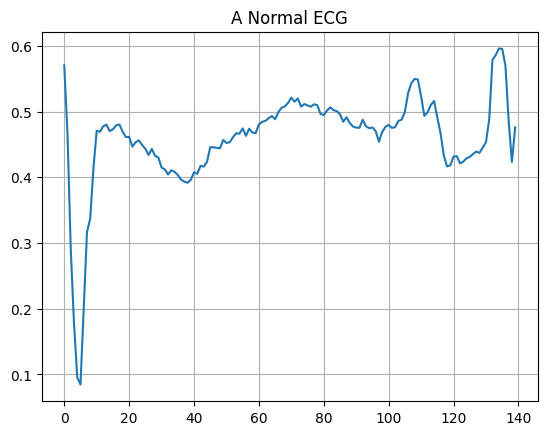

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

異常な ECG をプロットします。

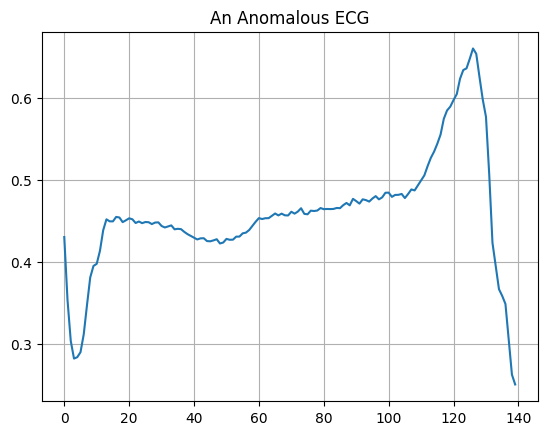

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### モデルを構築する

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

オートエンコーダは通常の ECG のみを使用してトレーニングされますが、完全なテストセットを使用して評価されることに注意してください。

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


1/5 [=====>........................] - ETA: 8s - loss: 0.0684

5/5 [==============================] - 2s 48ms/step - loss: 0.0619 - val_loss: 0.0539


Epoch 2/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0567

5/5 [==============================] - 0s 16ms/step - loss: 0.0559 - val_loss: 0.0519


Epoch 3/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0549

5/5 [==============================] - 0s 16ms/step - loss: 0.0539 - val_loss: 0.0501


Epoch 4/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0517

5/5 [==============================] - 0s 16ms/step - loss: 0.0503 - val_loss: 0.0484


Epoch 5/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0472

5/5 [==============================] - 0s 16ms/step - loss: 0.0458 - val_loss: 0.0480


Epoch 6/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0436

5/5 [==============================] - 0s 16ms/step - loss: 0.0421 - val_loss: 0.0453


Epoch 7/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0395

5/5 [==============================] - 0s 16ms/step - loss: 0.0380 - val_loss: 0.0425


Epoch 8/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0360

5/5 [==============================] - 0s 16ms/step - loss: 0.0348 - val_loss: 0.0413


Epoch 9/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0332

5/5 [==============================] - 0s 16ms/step - loss: 0.0322 - val_loss: 0.0404


Epoch 10/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0317

5/5 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0392


Epoch 11/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0290

5/5 [==============================] - 0s 17ms/step - loss: 0.0283 - val_loss: 0.0384


Epoch 12/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0272

5/5 [==============================] - 0s 17ms/step - loss: 0.0269 - val_loss: 0.0376


Epoch 13/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0265

5/5 [==============================] - 0s 16ms/step - loss: 0.0257 - val_loss: 0.0368


Epoch 14/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0362


Epoch 15/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 17ms/step - loss: 0.0240 - val_loss: 0.0355


Epoch 16/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 17ms/step - loss: 0.0233 - val_loss: 0.0351


Epoch 17/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0234

5/5 [==============================] - 0s 17ms/step - loss: 0.0226 - val_loss: 0.0347


Epoch 18/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 16ms/step - loss: 0.0221 - val_loss: 0.0344


Epoch 19/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0213

5/5 [==============================] - 0s 16ms/step - loss: 0.0217 - val_loss: 0.0342


Epoch 20/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0217

5/5 [==============================] - 0s 16ms/step - loss: 0.0213 - val_loss: 0.0340


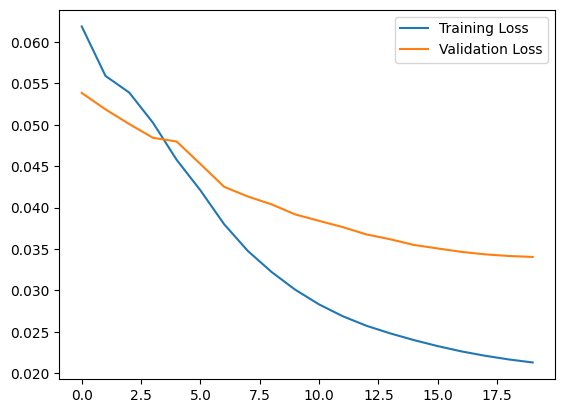

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

再構成エラーが正常なトレーニング例からの1標準偏差より大きい場合、ECG を異常として分類します。まず、トレーニングセットからの正常な ECG、オートエンコーダーによりエンコードおよびデコードされた後の再構成、および再構成エラーをプロットします。

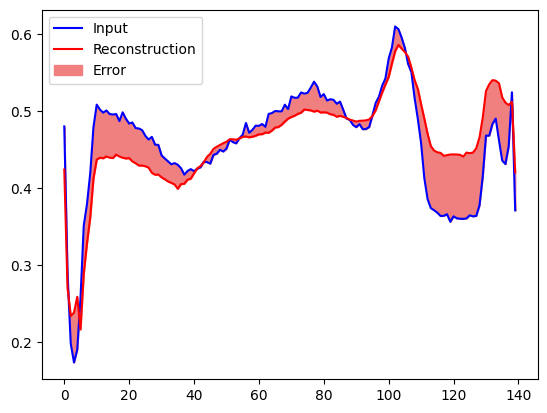

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

異常なテストサンプルで同様にプロットを作成します。

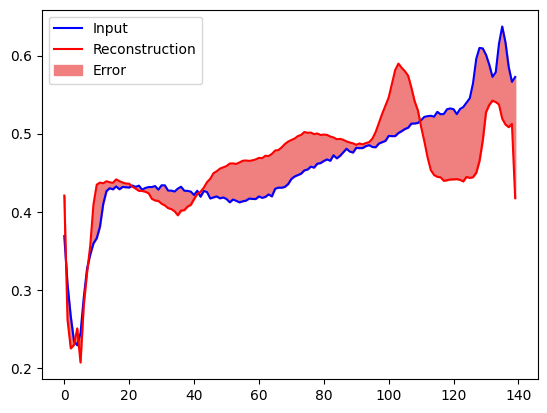

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 異常を検出します

再構成損失が指定してしきい値より大きいかどうかを計算することにより、異常を検出します。このチュートリアルでは、トレーニングセットから正常なサンプルの平均平均誤差を計算し、再構成誤差がトレーニングセットからの1標準偏差よりも大きい場合、以降のサンプルを異常として分類します。


トレーニングセットからの通常の ECG に再構成エラーをプロットします

 1/74 [..............................] - ETA: 8s

37/74 [==============>...............] - ETA: 0s

74/74 [==============================] - 0s 1ms/step


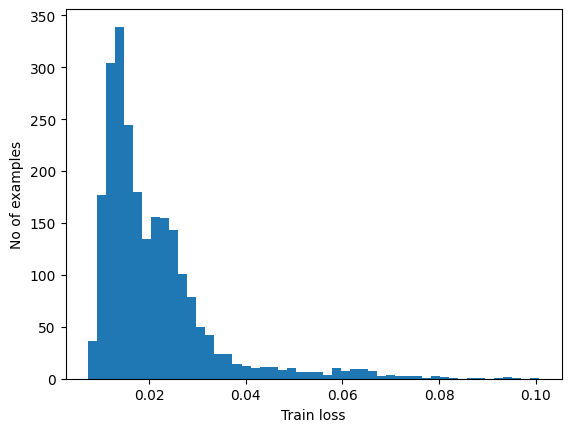

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

平均より1標準偏差上のしきい値を選択します。

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0331916


注意: テストサンプルを異常として分類するしきい値を選択するために使用できるアプローチは他にもあります。適切なアプローチはデータセットによって異なります。詳細については、このチュートリアルの最後にあるリンクを参照してください。 

テストセットの異常なサンプルの再構成エラーを調べると、ほとんどの場合、再構成エラーはしきい値よりも大きいことがわかります。しきい値を変更することで、分類器の[精度](https://developers.google.com/machine-learning/glossary#precision)と[リコール](https://developers.google.com/machine-learning/glossary#recall)を調整できます。 

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 2ms/step


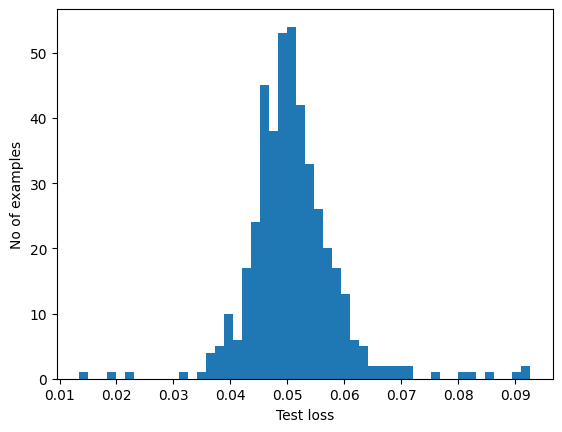

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

再構成エラーがしきい値よりも大きい場合は、ECG を異常として分類します。

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714


## 次のステップ

オートエンコーダによる異常検出の詳細については、Victor Dibia が TensorFlow.js で構築したこの優れた[インタラクティブな例](https://anomagram.fastforwardlabs.com/#/)をご覧ください。実際の使用例については、TensorFlow を使用して[Airbus が ISS テレメトリデータの異常を検出する方法](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)を参照してください。基本の詳細については、François Chollet によるこの[ブログ投稿](https://blog.keras.io/building-autoencoders-in-keras.html)をご一読ください。詳細については、Ian Goodfellow、Yoshua Bengio、Aaron Courville による[ディープラーニング](https://www.deeplearningbook.org/)の第 14 章をご覧ください。
